## Model Training

### 1.1 Import Packages and Data

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
# SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution
from imblearn.over_sampling import SMOTE , ADASYN

# FEature Importance
import shap
from sklearn.inspection import permutation_importance


# Preprocessing
from sklearn.preprocessing import RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline

# Error handling
import warnings
warnings.filterwarnings("ignore")

C:\Users\efrui\anaconda3\envs\TelcomChurnModel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/customer_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complaints               3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

### Drop Duplicate

In [4]:
df.drop_duplicates(inplace=True)  # Remove duplicate rows

### Preparing X and Y variables

In [5]:
X = df.drop(columns=['Churn']).copy()

In [6]:
X.head()

,Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805


In [7]:
df.columns

Index(['Call Failure', 'Complaints', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [8]:
y = df['Churn']
y

0       0
1       0
2       0
3       0
4       0
       ..
3096    0
3097    0
3099    1
3123    0
3131    1
Name: Churn, Length: 2850, dtype: int64

### Split Data into Test and Train

The distribution of "churned" vs. "not churned" is uneven, the default split (train_test_split) will likely result in an even further imbalance in the training and testing datasets. This could lead to poor model performance, especially for the underrepresented class.

The best approach would be to stratify the split, which ensures that the proportion of each class in the target variable (Churn) is maintained in both the training and testing datasets.

In [9]:
# Stratified split to maintain the same proportion(distribution) of each class
# Split into Train (60%) and Temp (40%) 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split Temp into Validation (20%) and Test+Raw (20%) 
X_val, X_temp, y_val, y_temp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#Split Temp into Test (10%) and Raw (10%) 
X_test, X_raw, y_test, y_raw = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print class distribution in each split
print("Train Distribution:\n", y_train.value_counts(normalize=True))
print("Validation Distribution:\n", y_val.value_counts(normalize=True))
print("Test Distribution:\n", y_test.value_counts(normalize=True))
print("Raw Data Distribution:\n", y_raw.value_counts(normalize=True))

Train Distribution:
 Churn
0    0.843275
1    0.156725
Name: proportion, dtype: float64
Validation Distribution:
 Churn
0    0.84386
1    0.15614
Name: proportion, dtype: float64
Test Distribution:
 Churn
0    0.842105
1    0.157895
Name: proportion, dtype: float64
Raw Data Distribution:
 Churn
0    0.845614
1    0.154386
Name: proportion, dtype: float64


### Preprocessing

I used Robust scalar because of the presence of outliers in the orginal datasets.


In [10]:
# Define feature groups
binary_columns = ['Tariff Plan', 'Status', 'Complaints']
ordinal_columns = ['Age Group', 'Charge Amount']
log_transform_columns = ['Call Failure', 'Frequency of use', 'Frequency of SMS', 'Age']  # Columns for log transform
boxcox_transform_columns = ['Seconds of Use', 'Distinct Called Numbers', 'Customer Value']  # Columns for Box-Cox
reflect_transform_columns = ['Subscription Length']  # Columns for reflection transform
numerical_vars = log_transform_columns + boxcox_transform_columns + reflect_transform_columns

In [11]:
def binary_change(x):
    """Convert 1 to 0 and 2 to 1 for binary columns that need it."""
    return np.where(x == 2, 1, np.where(x == 1, 0, x))

# 4. Apply binary transformation only to selected columns
def selective_binary_transform(X, columns_to_transform):
    """Apply binary_change only to specified columns."""
    X_transformed = X.copy()
    for i, col in enumerate(columns_to_transform):
        X_transformed[:, i] = binary_change(X_transformed[:, i])
    return X_transformed

# 5. Box-Cox transformation (ensures positive values)
def boxcox_transform(x):
    """Apply Box-Cox transformation ensuring positive values"""
    x = np.clip(x, 1e-6, None)  # Ensure values are positive (>0)
    return np.column_stack([boxcox(x[:, i])[0] for i in range(x.shape[1])])

# 6. Reflect transformation for 'Subscription Length'
def reflect_transform(x):
    """Apply reflection transformation to 'Subscription Length'"""
    return np.max(x, axis=0) - x

In [12]:
preprocessor = ColumnTransformer([
    # 1. Binary columns: Impute missing values and apply selective binary transformation
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('selective_binary', FunctionTransformer(
            lambda X: selective_binary_transform(X, columns_to_transform=['Tariff Plan', 'Status']),
            validate=False
        ))
    ]), binary_columns),

    # 2. Ordinal columns: Impute and scale
    ('ord', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ]), ordinal_columns),

    # 3. Log transform specific columns (including Call Efficiency)
    ('log', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', RobustScaler())
    ]), log_transform_columns),  # Now Call Efficiency is part of log transform

    # 4. Box-Cox transform specific columns
    ('boxcox', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('boxcox_transform', FunctionTransformer(boxcox_transform, validate=False)),
        ('scaler', RobustScaler())
    ]), boxcox_transform_columns),

    # 5. Reflect and log transform Subscription Length
    ('reflect', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('reflect_transform', FunctionTransformer(reflect_transform, validate=False)),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', RobustScaler())
    ]), reflect_transform_columns),

])


In [13]:


# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)
X_raw_transformed = preprocessor.transform(X_raw)


In [14]:
X_train_transformed.shape

(1710, 13)

In [15]:
df.shape

(2850, 14)

*Based off Preprocessing steps these are the columns in new order*

In [16]:
def get_feature_names(preprocessor, original_feature_names):
    """Extracts transformed feature names from ColumnTransformer."""
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if isinstance(columns, list) or isinstance(columns, np.ndarray):
            col_names = list(columns)
        else:
            col_names = original_feature_names[columns]  # Handle slices

        # If the transformer is a Pipeline, get its last step
        if isinstance(transformer, Pipeline):
            transformer = transformer[-1]

        # Maintain original column names without adding suffixes
        feature_names.extend(col_names)

    return feature_names

# Get transformed feature names
transformed_feature_names = get_feature_names(preprocessor, X_train.columns)

# Print feature names in order of the transformed array
print(transformed_feature_names)


['Tariff Plan', 'Status', 'Complaints', 'Age Group', 'Charge Amount', 'Call Failure', 'Frequency of use', 'Frequency of SMS', 'Age', 'Seconds of Use', 'Distinct Called Numbers', 'Customer Value', 'Subscription Length']


### Evaluation Metric Function

In [17]:
# Function to evaluate models using classification metrics
def evaluate_classification_model(y_train, y_train_pred, y_test, y_test_pred):
    def compute_scores(y_true, y_pred):
        return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred), roc_auc_score(y_true, y_pred)

    train_scores = compute_scores(y_train, y_train_pred)
    test_scores = compute_scores(y_test, y_test_pred)
    variance = tuple(t - te for t, te in zip(train_scores, test_scores))

    return train_scores, test_scores, variance

since the  dataset is small  and imbalanced (15.6% making churn customers), I'd be adjusting class weights and applying oversampling the under represented class (churned-1) to avoid data and information loss.

In [18]:

# Initialize ADASYN with desired ratio for generating synthetic samples
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_transformed, y_train)

# Check the distribution of classes after ADASYN
print(f'Before ADASYN: {y_train.value_counts()}')
print(f'After ADASYN: {pd.Series(y_train_resampled).value_counts()}')


Before ADASYN: Churn
0    1442
1     268
Name: count, dtype: int64
After ADASYN: Churn
1    1454
0    1442
Name: count, dtype: int64


*Compute Class Weights*

In [19]:

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_resampled), class_weights)}

# Compute scale_pos_weight for CatBoost
scale_pos_weight = class_weight_dict[0] / class_weight_dict[1]


In [20]:
# Define models with class weights where necessary
models = {
    "Logistic Regression": LogisticRegression(class_weight=class_weight_dict, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    "CatBoosting Classifier": CatBoostClassifier(scale_pos_weight=scale_pos_weight, verbose=0, random_seed=42),
    "SVC": SVC(class_weight=class_weight_dict, probability=True, random_state=42),
}

In [21]:

# Define hyperparameter grids for RandomizedSearchCV (to be customized)
param_grids = {
    "Logistic Regression": {
        'C': [500, 1000],  # Regularization strength
        'solver': ['liblinear', 'lbfgs'],  # Optimization algorithms
        'max_iter': [100, 200, 300, 400]  # Maximum iterations for convergence
    },
    "Random Forest Classifier": {
        'n_estimators': [50, 100, 200, 500],  # Number of trees
        'max_depth': [None, 10, 20, 30],  # Depth of trees
        'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
        'min_samples_leaf': [1, 2, 4],  # Minimum samples at leaf node
        'max_features': ['auto', 'sqrt', 'log2']  # Maximum features to consider at split
    },
    "CatBoosting Classifier": {
        'iterations': [100, 200, 300],  # Number of boosting iterations
        'learning_rate': [0.01, 0.05, 0.1],  # Step size for each boosting round
        'depth': [4, 6, 8],  # Depth of trees
        'l2_leaf_reg': [1, 3, 5],  # L2 regularization coefficient
        'subsample': [0.6, 0.8, 1]  # Fraction of samples used for fitting each tree
    },
    "SVC": {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Kernel type
        'gamma': ['scale', 'auto'],  # Kernel coefficient
        'degree': [3, 4, 5,10]  # Degree of the polynomial kernel
    },
}

In [22]:
# Lists to store results
model_list = []
auc_list = []

# Dictionary to store the best parameters for each model
best_params = {}
# Dictionary to store trained models
trained_models = {}

In [23]:
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Hyperparameter tuning
    if model_name in param_grids:
        print("Performing RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_distributions=param_grids[model_name],
                                    n_iter=10, random_state=42, n_jobs=-1, cv=3)
        search.fit(X_train_resampled, y_train_resampled)
        model = search.best_estimator_
        best_params[model_name] = search.best_params_

    # Train model
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[model_name] = model  # Store the trained model

    # Predict on train and validation sets
    y_train_pred = model.predict(X_train_resampled)
    y_val_pred = model.predict(X_val_transformed)

    # Evaluate train and validation scores
    train_scores, val_scores, variance = evaluate_classification_model(y_train_resampled, y_train_pred, y_val,
                                                                       y_val_pred)

    print(f"\n {model_name} Results")
    print("-" * 30)
    print(
        f"\n Train Scores: Accuracy: {train_scores[0]:.4f}, Precision: {train_scores[1]:.4f}, Recall: {train_scores[2]:.4f}, F1-Score: {train_scores[3]:.4f}, AUC: {train_scores[4]:.4f}")
    print(
        f" Validation Scores: Accuracy: {val_scores[0]:.4f}, Precision: {val_scores[1]:.4f}, Recall: {val_scores[2]:.4f}, F1-Score: {val_scores[3]:.4f}, AUC: {val_scores[4]:.4f}")
    print(
        f" Variance: Accuracy: {variance[0]:.4f}, Precision: {variance[1]:.4f}, Recall: {variance[2]:.4f}, F1-Score: {variance[3]:.4f}, AUC: {variance[4]:.4f}")

    # Store results
    model_list.append(model_name)
    auc_list.append(val_scores[4])

# Model comparison
results = pd.DataFrame({'Model': model_list, 'AUC': auc_list})
print("\nModel Comparison:")
print(results)


Training Logistic Regression...
Performing RandomizedSearchCV...

 Logistic Regression Results
------------------------------

 Train Scores: Accuracy: 0.8367, Precision: 0.8457, Recall: 0.8253, F1-Score: 0.8354, AUC: 0.8367
 Validation Scores: Accuracy: 0.8228, Precision: 0.4639, Recall: 0.8652, F1-Score: 0.6039, AUC: 0.8401
 Variance: Accuracy: 0.0139, Precision: 0.3818, Recall: -0.0399, F1-Score: 0.2314, AUC: -0.0034
Training Random Forest Classifier...
Performing RandomizedSearchCV...

 Random Forest Classifier Results
------------------------------

 Train Scores: Accuracy: 0.9986, Precision: 0.9973, Recall: 1.0000, F1-Score: 0.9986, AUC: 0.9986
 Validation Scores: Accuracy: 0.9368, Precision: 0.8046, Recall: 0.7865, F1-Score: 0.7955, AUC: 0.8756
 Variance: Accuracy: 0.0618, Precision: 0.1927, Recall: 0.2135, F1-Score: 0.2032, AUC: 0.1230
Training CatBoosting Classifier...
Performing RandomizedSearchCV...

 CatBoosting Classifier Results
------------------------------

 Train Scor

#### Insight: 
The ability of the model predicting true positive which is precision is more importatnt to me, and to do this I also need to take into consideration overfitting between train and validation set, this means variance is important and choosing model with the lowest variance is paramount. With that being said, CatBoosting Classifiers performs the best overall.  

In [24]:
# Store model names and their AUC scores in a list of tuples
model_auc_pairs = list(zip(model_list, auc_list))

In [25]:
# Sort the list by AUC in descending order
sorted_model_auc_pairs = sorted(model_auc_pairs, key=lambda x: x[1], reverse=True)


In [26]:
#print the sorted results
for model_name, auc in sorted_model_auc_pairs:
    print(f"{model_name}: Val AUC = {auc:.4f}")

SVC: Val AUC = 0.8933
CatBoosting Classifier: Val AUC = 0.8862
Random Forest Classifier: Val AUC = 0.8756
Logistic Regression: Val AUC = 0.8401


#### Feature Importance

In [53]:
# Feature importance analysis for Catboost model
for model_name, model in trained_models.items():
    if isinstance(model, CatBoostClassifier):
        print(f"Feature Importance for {model_name}:")

        # Get feature importance values
        feature_importances = model.get_feature_importance()

        # Ensure transformed feature names exist
        if 'transformed_feature_names' in locals() and len(transformed_feature_names) == len(feature_importances):
            feature_names = transformed_feature_names
        else:
            feature_names = [f"Feature_{i}" for i in range(len(feature_importances))]  # Fallback to indices

        # Create DataFrame with feature importance
        feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

        # Sort by importance without resetting the index
        top_features_df = feature_imp_df.sort_values(by='Importance', ascending=False)

        # Get only the top N features
        top_features = top_features_df.head(10)

        # Print results
        print(top_features_df)

Feature Importance for CatBoosting Classifier:
                    Feature  Importance
1                    Status   15.060720
12      Subscription Length   12.454266
2                Complaints   11.695471
10  Distinct Called Numbers   10.439507
6          Frequency of use   10.313013
5              Call Failure    9.190873
9            Seconds of Use    8.131267
8                       Age    6.644082
7          Frequency of SMS    5.410527
11           Customer Value    4.993529
3                 Age Group    4.944099
4             Charge Amount    0.613440
0               Tariff Plan    0.109207


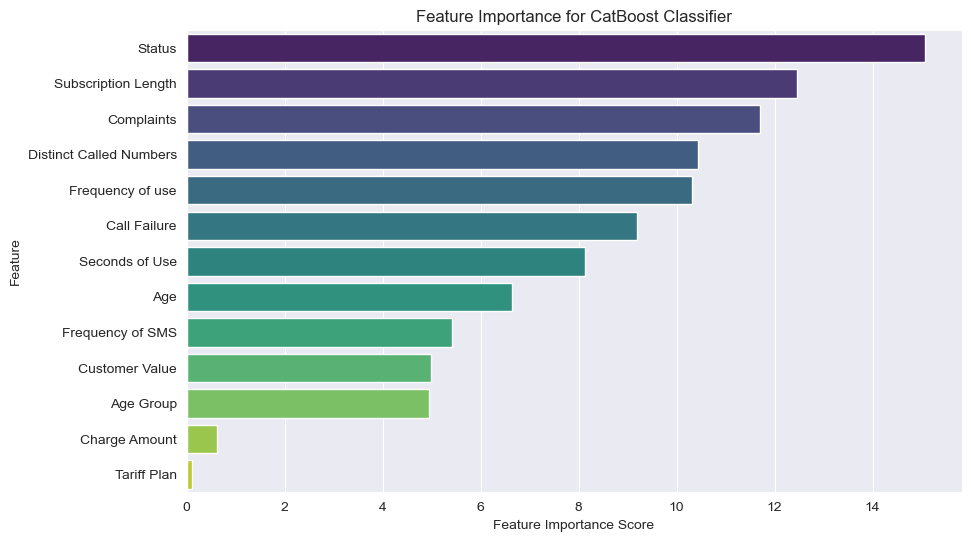

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features_df, palette="viridis")

# title
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for CatBoost Classifier")
plt.show()

#### Insights
Status Strongly affects churn prediction, 
Subscription Length is also Highly influential, Longer/shorter subscriptions may indicate churn. 
More complaints leads to higher churn risk. 
How often customers use the service also impacts churn.
Least important	feature, the Tariff plan has minimal impact on churn.

### Retrain best model with important features 

In [56]:
# Store feature indices of the top 10 important features
selected_feature_indices = top_features.index.tolist()

print(f"Selected Feature Indices:{selected_feature_indices}")

Selected Feature Indices:[1, 12, 2, 10, 6, 5, 9, 8, 7, 11]


In [37]:
best_params

{'Logistic Regression': {'solver': 'liblinear', 'max_iter': 100, 'C': 500},
 'Random Forest Classifier': {'n_estimators': 500,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': None},
 'CatBoosting Classifier': {'subsample': 0.8,
  'learning_rate': 0.05,
  'l2_leaf_reg': 5,
  'iterations': 300,
  'depth': 8},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 10, 'C': 100}}

#### Prepare Training Data

In [ ]:
# keep needed features in training data

X_train_selected = X_train_resampled[:, selected_feature_indices]

### Visualize Model Performance 

#### Confusion matrics


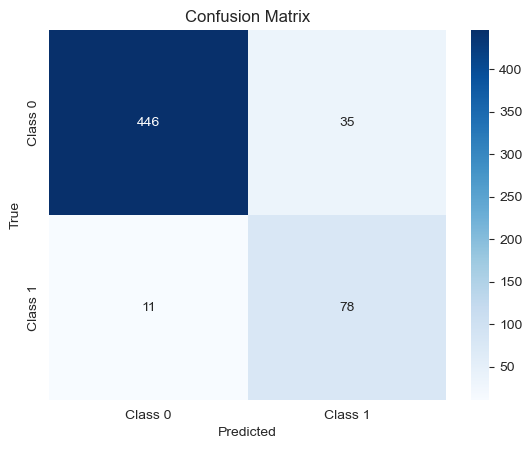

In [56]:
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

*Strengths*: The model successfully identifies most customers at risk of leaving(81/89), allowing for targeted retention efforts.

*Considerations*: It misclassifies some loyal customers (19 cases), meaning retention incentives could be given unnecessarily, but this trade off is acceptable given the high recall.

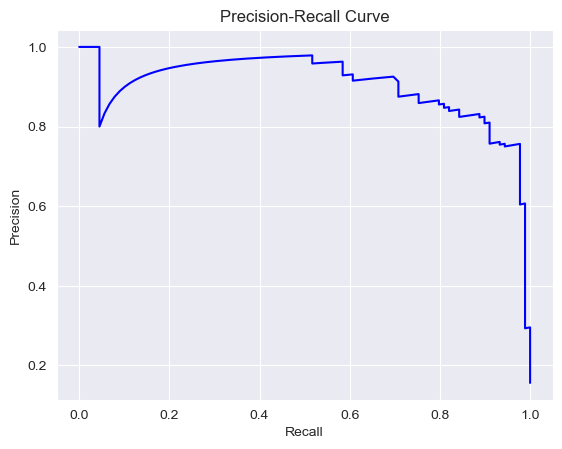

In [35]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### Insight :

The model maintains high precision even at high recall levels, meaning it can identify most churners while keeping false positives relatively low.

This means the  model is well calibrated for churn prediction. The businesses can trust its flagged churners and take action without excessive wasted effort on false alarms

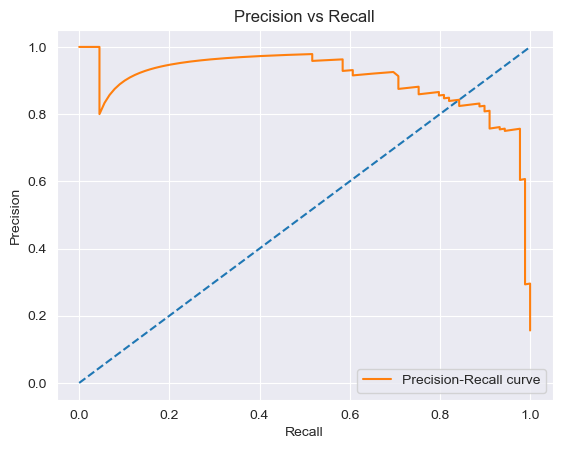

In [36]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend(loc='best')
plt.show()

#### Insight

The diagonal dashed line represents a random classifier, meaning it has no predictive power.
it would classify churn and non-churn customers purely by chance.


The model's orange precision recall curve ; is well above this line, meaning it can correctly identify churners better than random guessing